# Clustering sequential data using Hidden Markov Models
In this notebook, we will learn about Hidden Markov Models that find applications can be used for clustering. To start with, we on a single time-series whose time-points are to be separated into two clusters. As for mixture models, we will use the expectation-maximisation algorithm for optimisation.

We will again work with synthetic timeseries data generated through simulation of a Markov chain.

In [1]:
import random
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt

<a name="section-1"></a>

## Section 1: Hidden Markov Model

We start with the definition of a Hidden Markov Model (HMM). Here we consider the hidden states taking values $k=1,2,\ldots,K$, each state representing one of the clusters to be identified, to have a transition matrix $A$ and inital distribution $\pi$. We assume the emission probabilities to be multivariate normal distributions with mean $\mu_k$ and covariances $\Sigma_k$.

In [2]:
class HMM:
    """struct holding the parameters of the Hidden Markov Model"""
    """:param n_states: number of hidden states (clusters)"""
    """:param prior: initial distribution (pi)"""
    """:param A: transition matrix"""
    """:param n_dims: dimension of observations"""
    """:param mu: emission probability means for each cluster"""
    """:param sigma: emission probability covariance matrix for each cluster"""
    
    def __init__(self, n_states):
        """:param n_states: number of hidden states (K)"""
        self.n_states = n_states
        self.random_state = np.random.RandomState(0)
        
        #Normalize random initial state
        self.prior = normalize(self.random_state.rand(self.n_states, 1))
        self.A = normalize(self.random_state.rand(self.n_states, self.n_states))
        
        self.mu = None
        self.sigma = None
        self.n_dims = None
        
def initialise(model, obs):
    """initialises the parameters of the HMM from some observations"""
    if model.n_dims is None:
        model.n_dims = obs.shape[0]
    if model.mu is None:
        subset = model.random_state.choice(np.arange(model.n_dims), size=model.n_states, replace=False)
        model.mu = np.transpose(obs[:, subset])
    if model.sigma is None:
        model.sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))
        model.sigma += np.diag(np.diag(np.cov(obs)))[None, :, :]
        
def normalize(x):
    """Normalises vectors and matrices"""
    temp = x
    if len(x.shape)>1:
        for s in range(temp.shape[0]):
            temp[s,:] /= np.sum(temp[s,:])
        return temp
    else:
        return (x) / np.sum(x,0)

Let's start with a predefined model.

In [3]:
synModel = HMM(2)
initialise(synModel,np.array([[1,1],[1,1]]))
synModel.sigma[0]=np.array([[6, -3], [-3, 3.5]])
synModel.sigma[1]=np.array([[6, 3], [3, 3.5]])
synModel.mu[0]=np.array([4, 0])
synModel.mu[1]=np.array([12, 2])
synModel.A=normalize(np.array([[0.8, 0.2], [0.9, 0.1]]))

We like to sample from the model to generate some synthetic data.

In [4]:
## EDIT THIS FUNCTION
def sampleHMM(model, T=10):
       
    state_sequence=[]
    observation_sequence=[]
    
    weights = model.prior
    for t in range(T):
        state_sequence.append(random.choices(range(model.n_states), weights=weights)[0]) ### <- fill in
        observation_sequence.append(np.random.multivariate_normal(model.mu[state_sequence[-1]], model.sigma[state_sequence[-1]]))
        weights=model.A[state_sequence[-1],:]
    
    return np.array(state_sequence), np.array(observation_sequence) 

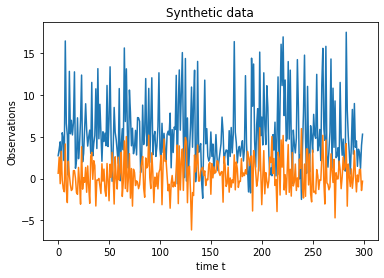

In [5]:
np.random.seed(42)
states1, obs1=sampleHMM(synModel,T=300)
plt.plot(obs1)
plt.xlabel("time t");
plt.ylabel("Observations");
plt.title("Synthetic data");

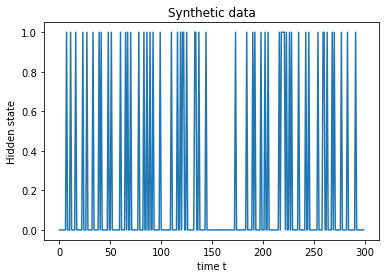

In [6]:
plt.plot(states1)
plt.xlabel("time t");
plt.ylabel("Hidden state");
plt.title("Synthetic data");

To visualise the emission probabilities, we again borrow some plot functions from the *Python Data Science Handbook* that we used to visualise the mixture model.

See https://jakevdp.github.io/PythonDataScienceHandbook/05.12-gaussian-mixtures.html

In [7]:
from matplotlib.patches import Ellipse
import matplotlib.pyplot as plt

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(model, X, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        labels = predict(model,X.T)
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2
    for pos, covar, w in zip(model.mu, model.sigma, model.prior):
        draw_ellipse(pos, covar, alpha=0.2)

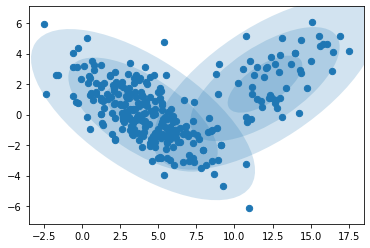

In [8]:
plot_gmm(synModel,obs1,label=False)

<a name="section-2"></a>

## Section 2: Temporal clustering using HMMs

Clustering in HMMs can be obtained through the forward-backward algorithm. The forward probability describes the probability of assigning clusters given the present and past observations:

$$\alpha_{tk} = P(Z_t=k|\boldsymbol{X}_{1:t}=\boldsymbol{x}_{1:t}).$$

Another way of clustering timeseries is to use the posterior distribution of states given past, present and future observations:

$$\gamma_{tk} = P(Z_t=k|\boldsymbol{X}_{1:T}=\boldsymbol{x}_{1:T}).$$

In [9]:
## EDIT THIS FUNCTION
def compute_emission_probabilites(model, obs):
    obs = np.atleast_2d(obs)
    B = np.zeros((model.n_states, obs.shape[1]))
    for s in range(model.n_states):
        B[s, :] = st.multivariate_normal.pdf(obs.T, mean=model.mu[s], cov=model.sigma[s]) ### <- fill in
    return B    

## EDIT THIS FUNCTION
def forwardbackward(model, B):
    """Implementation of the forward-backward algorithm"""
    """:param model: this is the HMM, emmission """
    """:param B: emission matrix """
    
    log_likelihood = 0.
    T = B.shape[1]
    
    # forward algorithm
    alpha = np.zeros(B.shape)
    for t in range(T):
        if t == 0:
            alpha[:, t] = B[:, t] * model.prior.ravel()
        else:
            alpha[:, t] = B[:, t] * np.dot(model.A.T, alpha[:, t - 1])

        alpha_sum = np.sum(alpha[:, t])
        alpha[:, t] /= alpha_sum
        log_likelihood = log_likelihood + np.log(alpha_sum)
    
    # backward algorithm
    beta = np.zeros(B.shape);
    beta[:, -1] = np.ones(B.shape[0])

    for t in range(T - 1)[::-1]:
        beta[:, t] = np.dot(model.A, (B[:, t + 1] * beta[:, t + 1]))
        beta[:, t] /= np.sum(beta[:, t])
        
    # smoothed solution
    gamma = np.zeros((model.n_states, T))
    for t in range(T):
        gamma[:, t] = alpha[:, t] * beta[:, t]  ### <- fill in   
    
    return log_likelihood, alpha, beta, gamma

def predict0(model, obs):
    """MAP of filtered cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, alpha, _, _ = forwardbackward(model,B)
        
    return np.argmax(alpha.T, axis=1)

def predict(model, obs):
    """MAP of smoothed cluster probabilities (hard clustering)"""
    B = compute_emission_probabilites(model, obs)
    T = B.shape[1]
    
    _, _, _, gamma = forwardbackward(model,B)
        
    return np.argmax(gamma.T, axis=1)


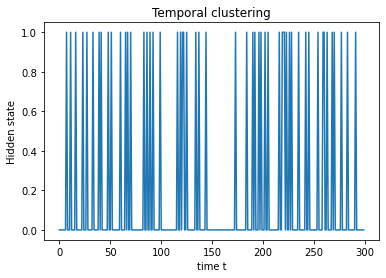

In [10]:
plt.plot(predict(synModel,obs1.T))
plt.xlabel("time t");
plt.ylabel("Hidden state");
plt.title("Temporal clustering");

Filtered and smoothed clustering distributions yield similar results.

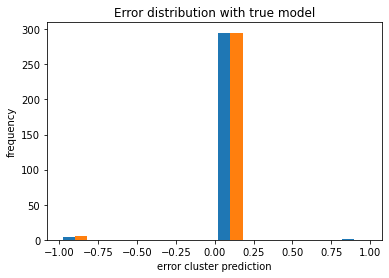

In [11]:
plt.hist([predict(synModel,obs1.T)-states1,predict0(synModel,obs1.T)-states1])
plt.xlabel("error cluster prediction");
plt.ylabel("frequency");
plt.title("Error distribution with true model");

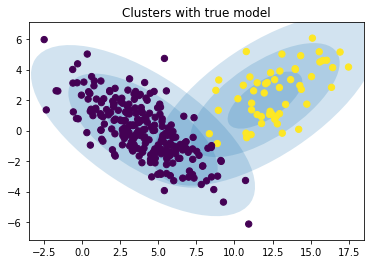

In [12]:
plot_gmm(synModel,obs1)
plt.title("Clusters with true model");

However, usually the true model is not known and has to be optimised from data.

<a name="section-3"></a>

## Section 3: Learning hyperparameters in HMMs

Optimising hyperparameters in HMMs is very similar to mixture models. We can use the distribution of 

In [13]:
## EDIT THIS FUNCTION
def em_step(model, obs): 
    """One step of the EM training for the HMM"""

    # initialise HMM if needed
    initialise(model,obs)

    obs = np.atleast_2d(obs)
    B = compute_emission_probabilites(model,obs)
    T = obs.shape[1]

    # evaluate forward and backward probabilities (E step)
    log_likelihood, alpha, beta, gamma = forwardbackward(model,B)

    #E-Step: update model        
    expected_prior = normalize(gamma[:, 0])        
    xi = np.zeros((model.n_states, model.n_states))
    for t in range(T - 1):
        xi += normalize(model.A * np.dot(alpha[:, t], (beta[:, t+1] * B[:, t + 1]).T))
    expected_A = normalize(xi)

    # M-Step: update mu and sigma              
    expected_mu = np.zeros((model.n_states, model.n_dims))
    expected_sigma = np.zeros((model.n_states, model.n_dims, model.n_dims))

    for s in range(model.n_states):
        weight = gamma[s,:]/(gamma[s,:].sum())            
        expected_mu[s] = (obs @ weight)
        expected_sigma[s] = np.cov(obs, aweights=weight, bias=True) ### <- fill in

    # update
    model.prior = expected_prior
    model.mu = expected_mu
    model.sigma = expected_sigma
    model.A = expected_A
    return log_likelihood


def train(model, obs, n_iter=1):
    """Several EM steps"""
    for i in range(n_iter):
        log_likelihood = em_step(model,obs)    

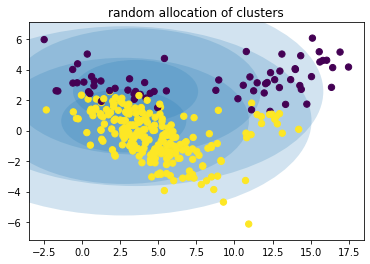

In [14]:
np.random.seed(42)
m1 = HMM(2)
initialise(m1,obs1.T)
plot_gmm(m1,obs1)
plt.title("random allocation of clusters");

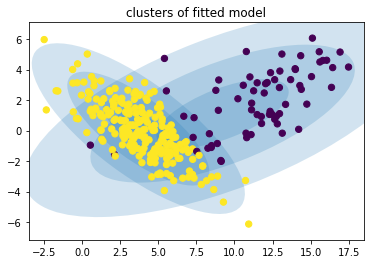

In [15]:
np.random.seed(42)
m1 = HMM(2)
train(m1,obs1.T,100)
plot_gmm(m1,obs1)
plt.title("clusters of fitted model");

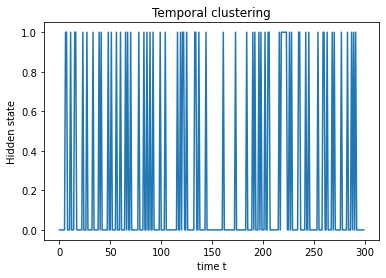

In [16]:
plt.plot(abs(predict(m1,obs1.T)-1))
plt.xlabel("time t");
plt.ylabel("Hidden state");
plt.title("Temporal clustering");

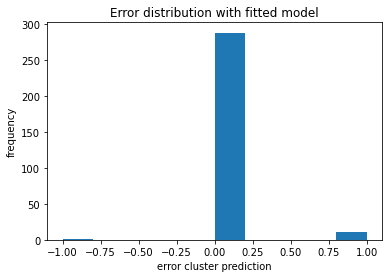

In [17]:
plt.hist([abs(predict(m1,obs1.T)-1)-states1])
plt.xlabel("error cluster prediction");
plt.ylabel("frequency");
plt.title("Error distribution with fitted model");

**Questions:**

* What are the differences between mixture model clustering and hidden Markov models clustering?
* How can we choose the number of clusters?
* What are the pros & cons of soft and hard clustering?